In [62]:
import numpy as np
from scipy.optimize import curve_fit, minimize_scalar, brentq, minimize
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_csv("/Users/juliogutierrez/Downloads/R-sidis_analysis/Carbon_luminosity.csv",sep="|")

run_num = df["run_num"].to_numpy();
I = df["current"].to_numpy();
runlength = df["run_length"].to_numpy();
Q = df["charge"].to_numpy();
prescale = df["PS4"].to_numpy();
N = df["yield_new"].to_numpy();
eff = df["efficiency"].to_numpy();
I2 = df["current2"].to_numpy();
Q2 = df["charge2"].to_numpy();
dead = df["deadtime"].to_numpy();
IA = df["currentA"].to_numpy();
QA = df["chargeA"].to_numpy();


norm = [None] * len(N)
Y_norm = [None] * len(N)
error = [None] * len(N)

norm2 = [None] * len(N)
Y_norm2 = [None] * len(N)
error2 = [None] * len(N)

# for i in range(len(nentries)):
#     norm[i] = prescale[i]/(charge[i] * eff[i] * hcDeadT[i])
#     norm_yield[i] = nentries[i]*norm[i]
#     error[i] = np.sqrt(nentries[i])*norm[i]

#     bcm2Norm[i] = prescale[i]/(bcm2Charge[i] * eff[i] * hcDeadT[i])
#     bcm2Yield[i] = nentries[i]*bcm2Norm[i]
#     bcm2Error[i] = np.sqrt(nentries[i])*bcm2Norm[i]


norm = prescale/(Q * eff * dead)
Y_norm= N*norm
error = np.sqrt(N)*norm

norm2 = prescale/(Q2 * eff * dead)
Y_norm2 = N*norm2
error2 = np.sqrt(N)*norm2

normA = prescale/(QA * eff * dead)
Y_normA = N*normA
errorA = np.sqrt(N)*normA

- Try BCM2
- Try determining offsets in the current -> modified charges

δ (C) = 0.168473 ± 0.029287 µA
Slope (C) = 16.984417 ± 0.028647
δ (A) = 0.149929 ± 0.029286 µA
Slope (A) = 16.983844 ± 0.028645
δ (2) = 0.080744 ± 0.029017 µA
Slope (2) = 17.140761 ± 0.028909


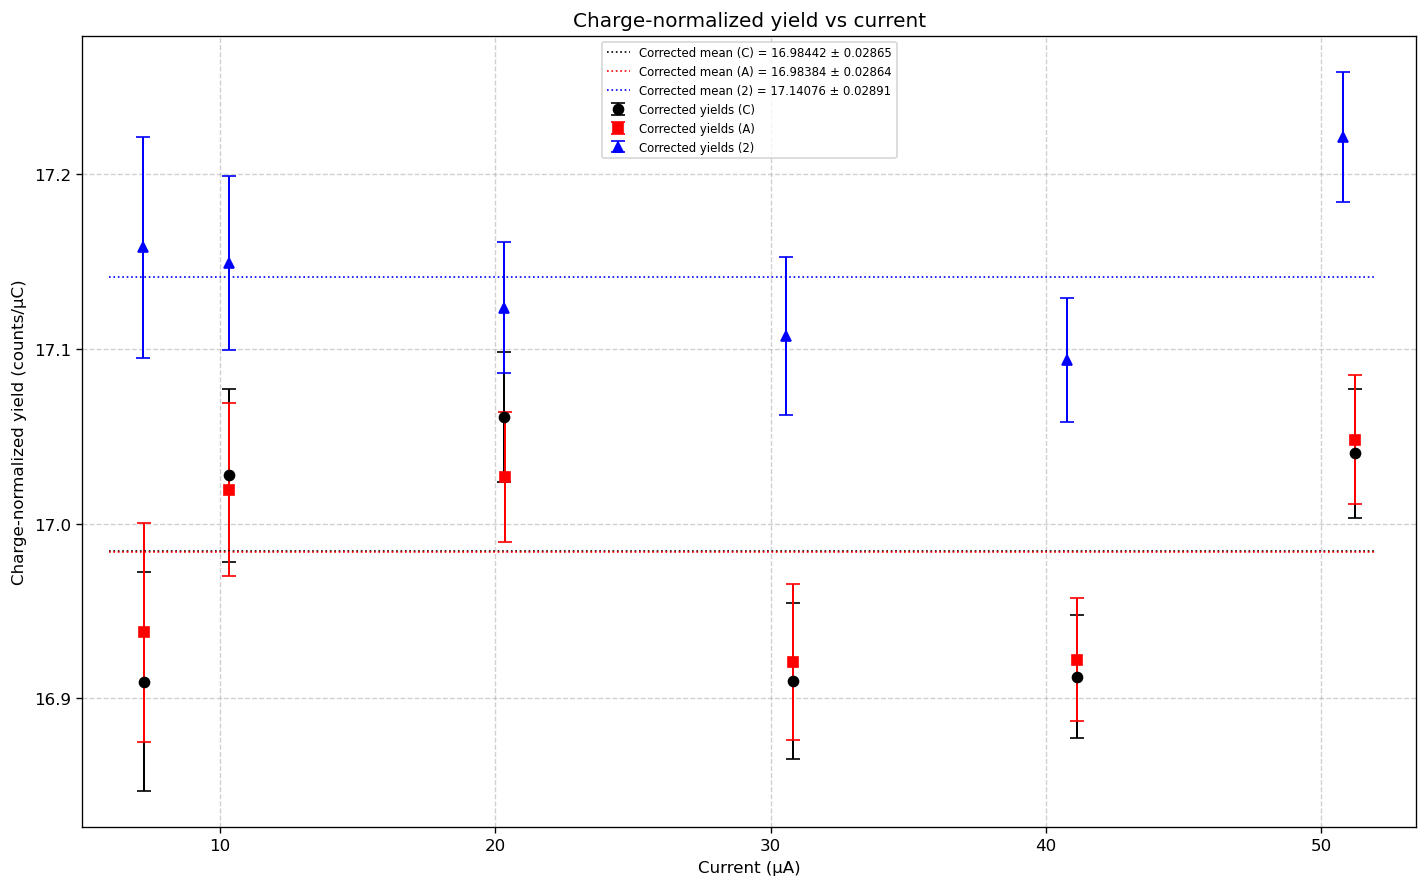

In [63]:
# Fit offset from raw data
def yield_model(I, delta, C):
    return C * (1 + delta / I)

popt, pcov = curve_fit(yield_model, I, Y_norm, sigma=error, absolute_sigma=True, p0=[0.0, np.mean(Y_norm)])
delta_fit, C_fit = popt
delta_err, C_err = np.sqrt(np.diag(pcov))

popt2, pcov2 = curve_fit(yield_model, I2, Y_norm2, sigma=error2, absolute_sigma=True, p0=[0.0, np.mean(Y_norm2)])
delta_fit2, C_fit2 = popt2
delta_err2, C_err2 = np.sqrt(np.diag(pcov2))

poptA, pcovA = curve_fit(yield_model, IA, Y_normA, sigma=errorA, absolute_sigma=True, p0=[0.0, np.mean(Y_normA)])
delta_fitA, C_fitA = poptA
delta_errA, C_errA = np.sqrt(np.diag(pcovA))

# Compute reduced chi-squared
# residuals = (Y_norm - yield_model(I, *popt)) / error
# chi2 = np.sum(residuals**2)
# ndof = len(I) - len(popt)
# chi2_red = chi2 / ndof

print(f"δ (C) = {delta_fit:.6f} ± {delta_err:.6f} µA")
print(f"Slope (C) = {C_fit:.6f} ± {C_err:.6f}")
print(f"δ (A) = {delta_fitA:.6f} ± {delta_errA:.6f} µA")
print(f"Slope (A) = {C_fitA:.6f} ± {C_errA:.6f}")
print(f"δ (2) = {delta_fit2:.6f} ± {delta_err2:.6f} µA")
print(f"Slope (2) = {C_fit2:.6f} ± {C_err2:.6f}")


# print(f"χ² = {chi2:.3f}, reduced χ² = {chi2_red:.3f} (ndof = {ndof})")

# Compute corrected yield with the optimized offset applied
factor_opt = 1 + delta_fit / I
Y_corr_opt = Y_norm / factor_opt
err_corr_opt = error / factor_opt

factor_optA = 1 + delta_fitA / IA
Y_corr_optA = Y_normA / factor_optA
err_corr_optA = errorA / factor_optA

factor_opt2 = 1 + delta_fit2 / I2
Y_corr_opt2 = Y_norm2 / factor_opt2
err_corr_opt2 = error2 / factor_opt2

# Plot
fig, ax = plt.subplots(figsize=(12,7.5), dpi=120)

# Raw (uncorrected yield) + fit
# ax.errorbar(I, Y_norm, yerr=error, fmt='s',elinewidth=1.2, capsize=4, label="Raw carbon yield (C)")
# ax.errorbar(IA, Y_normA, yerr=errorA, fmt='s',elinewidth=1.2, capsize=4, label="Raw carbon yield (A)")
# ax.errorbar(I2, Y_norm2, yerr=error2, fmt='s',elinewidth=1.2, capsize=4, label="Raw carbon yield (2)")

I_fit = np.linspace(min(I)-1, max(I)+1, 200)
# ax.plot(I_fit, yield_model(I_fit, delta_fit, C_fit), linestyle='dotted', label=f"Fit (C): δ = {delta_fit:.4f} ± {delta_err:.4f} µA")
# ax.plot(I_fit, yield_model(I_fit, delta_fitA, C_fitA), linestyle='dotted', label=f"Fit (A): δ = {delta_fitA:.4f} ± {delta_errA:.4f} µA")
# ax.plot(I_fit, yield_model(I_fit, delta_fit2, C_fit2), linestyle='dotted', label=f"Fit (2): δ = {delta_fit2:.4f} ± {delta_err2:.4f} µA")

# Corrected yield
ax.errorbar(I, Y_corr_opt, yerr=err_corr_opt, fmt='ko', elinewidth=1.2, capsize=4, label="Corrected yields (C)")
ax.errorbar(IA, Y_corr_optA, yerr=err_corr_optA, fmt='rs', elinewidth=1.2, capsize=4, label="Corrected yields (A)")
ax.errorbar(I2, Y_corr_opt2, yerr=err_corr_opt2, fmt='b^', elinewidth=1.2, capsize=4, label="Corrected yields (2)")
ax.axhline(C_fit, xmin=0.02, xmax=0.97, color='k', linestyle='dotted', linewidth=1, label=f"Corrected mean (C) = {C_fit:.5f} ± {C_err:.5f}")
ax.axhline(C_fitA, xmin=0.02, xmax=0.97, color='r', linestyle='dotted', linewidth=1, label=f"Corrected mean (A) = {C_fitA:.5f} ± {C_errA:.5f}")
ax.axhline(C_fit2, xmin=0.02, xmax=0.97, color='b', linestyle='dotted', linewidth=1, label=f"Corrected mean (2) = {C_fit2:.5f} ± {C_err2:.5f}")


# Improving presentation
ax.set_title("Charge-normalized yield vs current")
ax.set_xlabel("Current (µA)")
ax.set_ylabel("Charge-normalized yield (counts/µC)")
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(frameon=True, fontsize=7)
plt.tight_layout()
# plt.ylim(16.25,17.8)
plt.show()


δ = 0.080744 ± 0.029017 µA
C = 17.140761 ± 0.028909
χ² = 7.320, reduced χ² = 1.830 (ndof = 4)


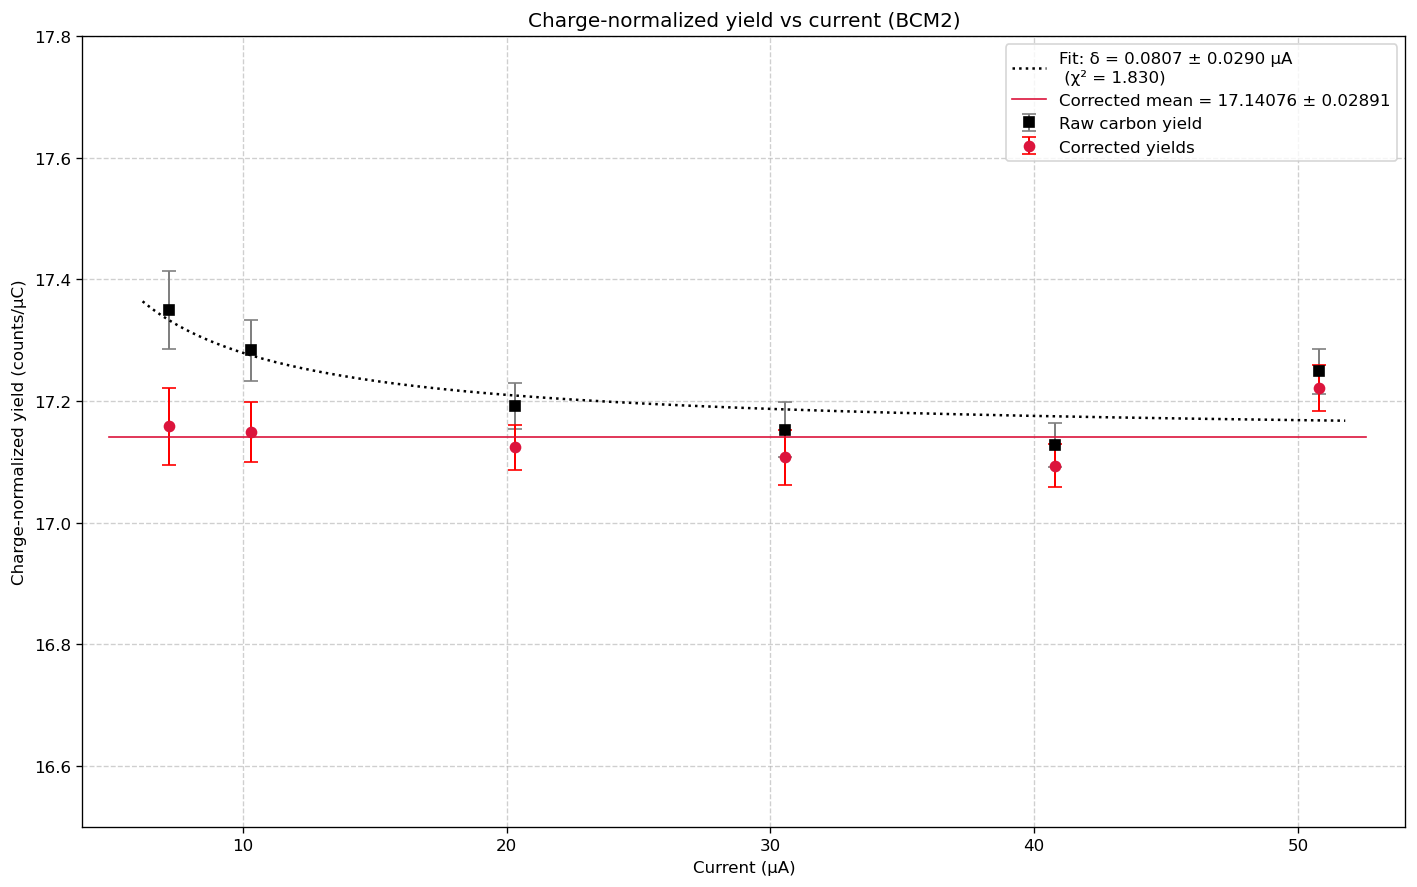

In [64]:

# Compute reduced chi-squared
residuals = (Y_norm2 - yield_model(I2, *popt2)) / error2
chi2 = np.sum(residuals**2)
ndof = len(I2) - len(popt2)
chi2_red = chi2 / ndof

print(f"δ = {delta_fit2:.6f} ± {delta_err2:.6f} µA")
print(f"C = {C_fit2:.6f} ± {C_err2:.6f}")
print(f"χ² = {chi2:.3f}, reduced χ² = {chi2_red:.3f} (ndof = {ndof})")


# Plot
fig, ax = plt.subplots(figsize=(12,7.5), dpi=120)

# Raw (uncorrected yield) + fit
ax.errorbar(I2, Y_norm2, yerr=error2, fmt='s', color='black', ecolor='gray',
            elinewidth=1.2, capsize=4, label="Raw carbon yield")
I_fit = np.linspace(min(I2)-1, max(I2)+1, 200)
ax.plot(I_fit, yield_model(I_fit, delta_fit2, C_fit2), color='black', linestyle='dotted',
        label=f"Fit: δ = {delta_fit2:.4f} ± {delta_err2:.4f} µA \n (χ² = {chi2_red:.3f})")

# Corrected yield
ax.errorbar(I2, Y_corr_opt2, yerr=err_corr_opt2, fmt='o', color='crimson',
            ecolor='red', elinewidth=1.2, capsize=4, label="Corrected yields")
ax.axhline(C_fit2, xmin=0.02, xmax=0.97, color='crimson', linestyle='-', linewidth=1,
           label=f"Corrected mean = {C_fit2:.5f} ± {C_err2:.5f}")


# Improving presentation
ax.set_title("Charge-normalized yield vs current (BCM2)")
ax.set_xlabel("Current (µA)")
ax.set_ylabel("Charge-normalized yield (counts/µC)")
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(frameon=True)
plt.tight_layout()
plt.ylim(16.5,17.8)
plt.show()
